# Visualize Tacotron2 TTS outputs

## Imports

In [1]:
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd

# ESPnet2 imports
import soundfile
import torch
from espnet_model_zoo.downloader import ModelDownloader
from espnet2.bin.tts_inference import Text2Speech
from espnet2.tts.gst.style_encoder import ReferenceEncoder
from espnet2.tts.gst.style_encoder import StyleTokenLayer
from espnet2.tts.tacotron2 import Tacotron2
from espnet2.tasks.tts import TTSTask

# ParallelWaveGAN imports
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

# Audio displaying
import IPython
from pathlib import Path
from skimage import io
import numpy as np

from torchvision.transforms import ToTensor
from itertools import islice
from Resemblyzer import resemblyzer
from Resemblyzer.demo_utils import *

from tqdm import tqdm

## Load model from checkpoint

In [37]:
# Load pretrained model
d = ModelDownloader('./models/')
config_weights = d.download_and_unpack("kan-bayashi/vctk_tts_train_gst_tacotron2_raw_phn_tacotron_g2p_en_no_space_train.loss.best")
oldtt2, _ = TTSTask.build_model_from_file(
    config_weights["train_config"], config_weights["model_file"]
)
_ = oldtt2.cuda().eval()

In [39]:
# Load finetuned model
config_weights = {
    "train_config" : "/home/bjorn/code/full_espnet/espnet/egs2/lrs3/tts1/exp_new/tts_train_fbank_phn_tacotron_g2p_en_no_space/config.yaml",
    "model_file" : "/home/bjorn/code/full_espnet/espnet/egs2/lrs3/tts1/exp2/tts_train_fbank_phn_tacotron_g2p_en_no_space/3epoch.pth"
}
tt2, train_args = TTSTask.build_model_from_file(
    config_weights["train_config"], config_weights["model_file"]
)

In [40]:
# Include feature extraction Module of pretrained system
# because TTS build task for some reason does not include it
tt2.feats_extract = oldtt2.feats_extract
#tt2.tts.enc = oldtt2.tts.enc
#tt2.tts.dec = oldtt2.tts.dec
_= tt2.cuda()
_ = tt2.eval()

In [41]:
vocoder_tag = "vctk_parallel_wavegan.v1"
vocoder = load_model(download_pretrained_model(vocoder_tag)).cuda().eval()
vocoder.remove_weight_norm()

## Prepare audio loading with feature extraction and text preprocessing

In [42]:
def load_audio(path):
    speech, fs = soundfile.read(path)
    speech = torch.from_numpy(speech).float().cuda()
    if tt2.feats_extract is not None:
        feats = tt2.feats_extract(speech[None])[0][0]
    else:
        feats = speech
    return tt2.normalize(feats[None])[0][0]

def load_base_audio(path):
    speech, fs = soundfile.read(path)
    return speech

In [43]:
preprocess = TTSTask.build_preprocess_fn(train_args, False)
def preprocess_text(text):
    return torch.from_numpy(preprocess("<dummy>", {"text": text})["text"])

## Prepare data plotting
Plotting function from [here](https://github.com/NVIDIA/tacotron2/blob/master/inference.ipynb).

In [44]:
def plot_data(data, audio, titles=None, figsize=(16, 4), suptitle="Plots"):
    fig, axes = plt.subplots(1, len(data)+1, figsize=figsize)
    fig.suptitle(suptitle, fontsize=16)
    for i in range(len(data)):
        ax = axes[i]
        ax.tick_params(left=False,
                bottom=True,
                labelleft=False,
                labelbottom=True)
        ax.imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
        if titles:
            ax.title.set_text(titles[i])
    axes[-1].tick_params(left=False,
                bottom=True,
                labelleft=False,
                labelbottom=True)
    axes[-1].plot(audio)
    axes[-1].title.set_text(titles[-1])
    plt.tight_layout()

## Load Audio sample for 10 speakers

In [45]:
total = 10
per_spk = 1
paths = []
audio = Path("/mnt/U/Datasets/lrs3pretrain/processed/audio_segments/pretrain")
for speaker in islice(audio.glob("*"), total):
    paths += list(speaker.glob("*.wav"))[:per_spk]
wavs = list(map(load_audio, tqdm(paths, "Preprocessing wavs", len(paths))))
orig_wavs = list(map(load_base_audio, tqdm(paths, "Loading wavs", len(paths))))
speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, paths))

Loading wavs: 100%|██████████| 10/10 [00:00<00:00, 4069.77it/s]


## Run Inference

In [46]:
text = preprocess_text("Hearing faces is very hard.") #that is longer just for the sake of being longer and it doesnt matter what is says")
features, alignments, out_speechs, stop_probs = [], [], [], []
with torch.no_grad():
    for tens in tqdm(wavs):
        tens = tens.cuda()
        c, stop_prob, alignment = tt2.tts.inference(text=text.cuda(), speech=tens, use_att_constraint=False)
        features.append(c)
        alignments.append(alignment)
        stop_probs.append(stop_prob)
        out_speechs.append(vocoder.inference(c))

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


In [47]:
for i, (speech, base) in enumerate(zip(out_speechs, orig_wavs)):
    speech = speech.view(-1).cpu().numpy()
    print(f"--------{int(i/per_spk)+1}: {speakers[i]} --------")
    IPython.display.display(IPython.display.Audio(speech, rate=24000))
    IPython.display.display(IPython.display.Audio(base, rate=24000))

--------1: 00j9bKdiOjk --------


--------2: 01GWGmg5jn8 --------


--------3: 03h0dNZoxr8 --------


--------4: 04SEzifEsGg --------


--------5: 04VbxnzUwes --------


--------6: 05jJodDVJRQ --------


--------7: 06M8qY7Q74Y --------


--------8: 08ZWROqoTZo --------


--------9: 0af00UcTOSc --------


--------10: 0akiEFwtkyA --------


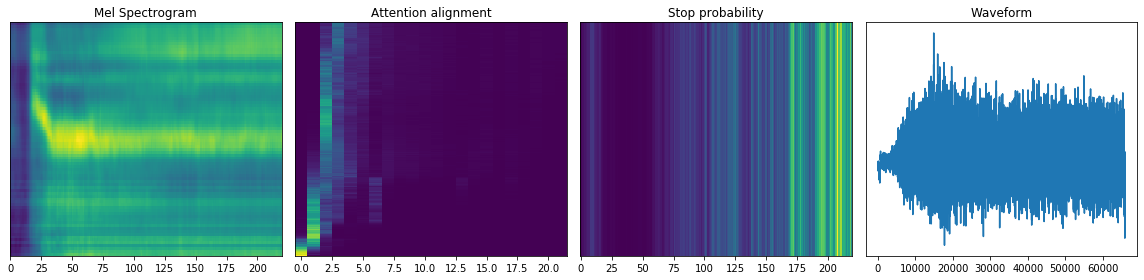

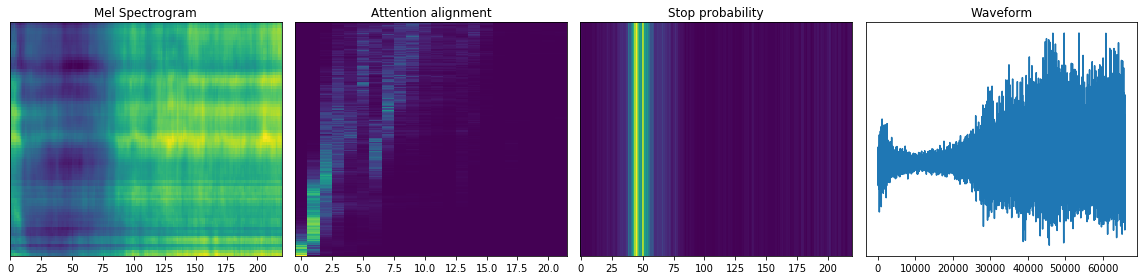

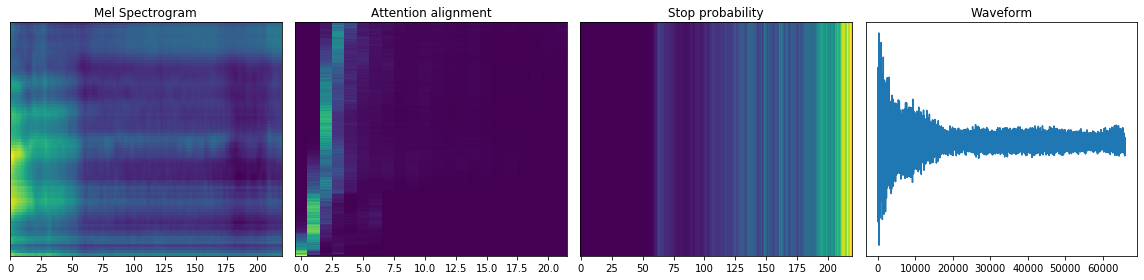

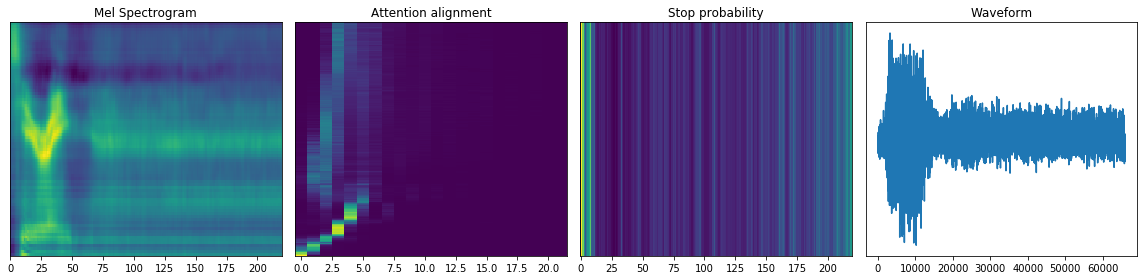

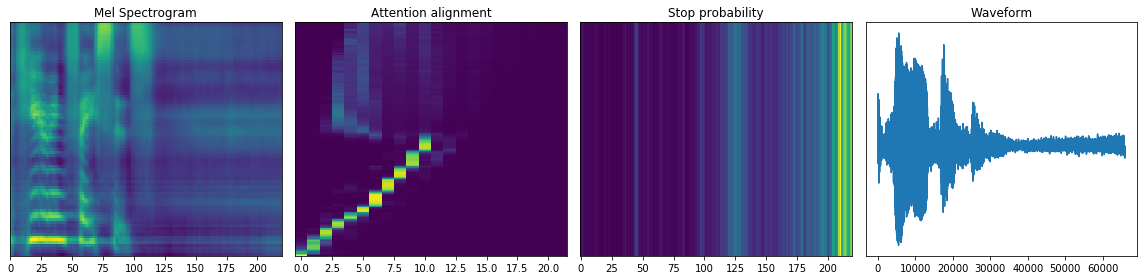

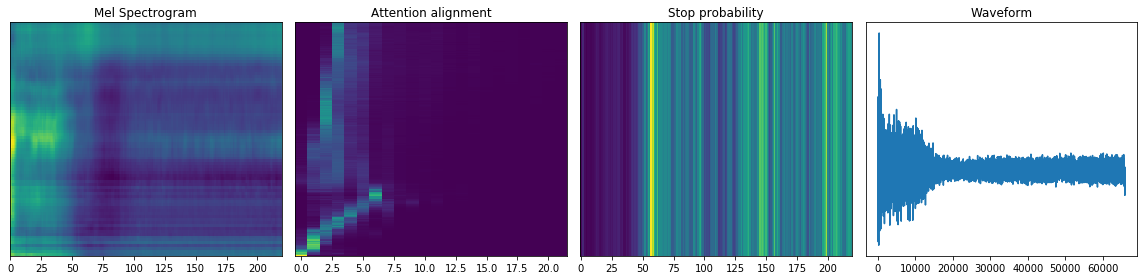

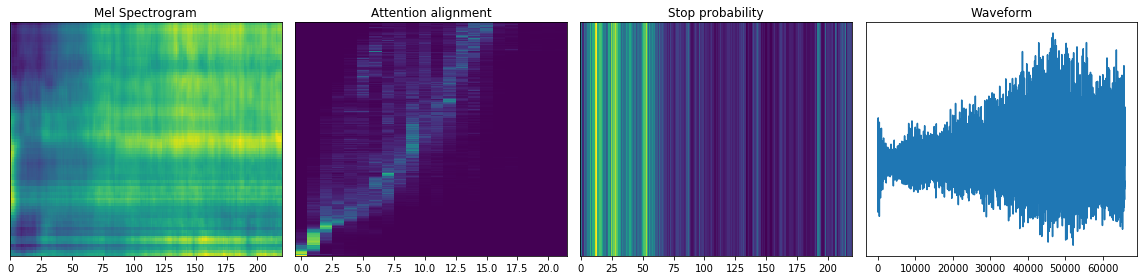

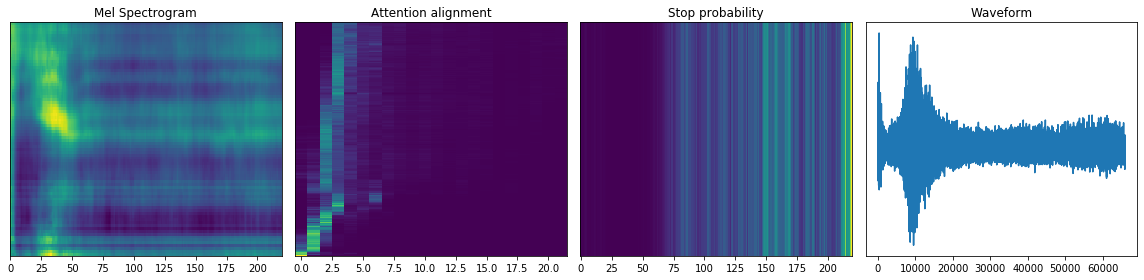

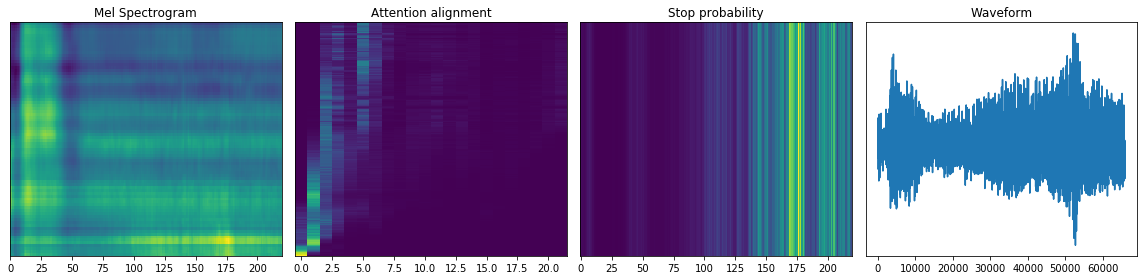

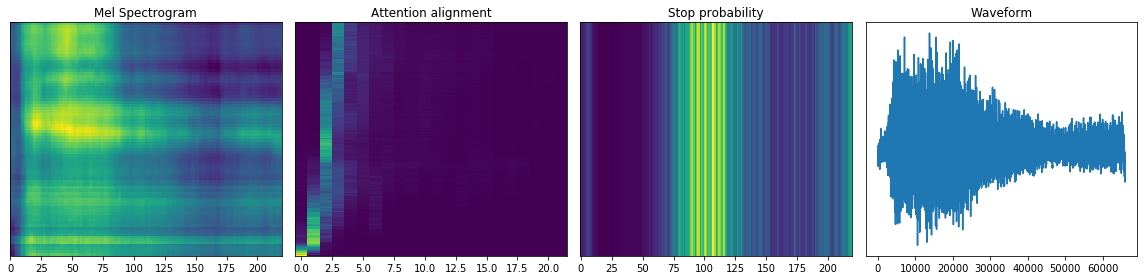

In [48]:
import librosa
for i, (speaker, feat, alignment, stop) in enumerate(zip(speakers, features, alignments, stop_probs)):
    plot_data(
        [feat.cpu().T, alignment.cpu(), stop.unsqueeze(0).cpu()], out_speechs[i].cpu(),
        titles=["Mel Spectrogram", "Attention alignment", "Stop probability", "Waveform"],
        suptitle=f""
    )
    plt.savefig(f"./plots/attention_gst_3_{i}.pdf")